# Amazon Titan Image Generator v2 Workshop: Creating a Visual Ad for Octank Dog Food

## Introduction

Welcome to the Amazon Titan Image Generator v2 Workshop! In this hands-on session, we'll explore the powerful capabilities of Amazon Titan Generator v2 to create a compelling visual ad for Octank, a premium dog food company.


### Use Case

Octank is launching a new dog food line and wants to create a visual ad. They have specific requirements:

1. Use an image of the owner's American Eskimo dog as inspiration for the product packaging design.
2. Create a special promotional package design using their brand color palette (yellow, blue, and gray).
3. Create a professional-looking ad with the product in filming studio background.


### Workshop Objectives

By the end of this workshop, you will:

1. Understand the key features of Amazon Titan Image Generator v2
2. Learn how to use these features for a real-world marketing scenario
3. Gain hands-on experience with the Amazon Bedrock API for image generation tasks

### Features We'll Use

During the workshop, we'll leverage the following features of Amazon Titan Image Generator v2:

1. Text-to-Image: To create an initial product package design based on text description
2. Image Conditioning: To create an initial product package design inspired by the reference image 
3. Image Variation: To create a new version of the reference image by adding more details
4. Inpainting: Add more details in a specific area of the reference image
5. Color Conditioning: To generate a special promotional package design using Octank's brand color palette
6. Outpainting: To create a professional-looking ad with product in filming studio background
7. Background Removal: To isolate the product image for use in various marketing materials
8. Responsible AI - Blocked Prompts that are not appropriate

## Setup


In [155]:
# Built-in libraries
import base64
import io
import json
import os
import sys

# External dependencies
import boto3
import botocore
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# Set up Bedrock client
boto3_bedrock = boto3.client('bedrock-runtime')

The following ultilty function visualizes generated images alongside optional reference images. It's essential for displaying and comparing the results of image generation tasks, allowing you to easily see the input, output, and any relevant color information in a single, organized plot.

In [156]:
# Utility function: Define plot function
def plot_images(base_images, prompt=None, seed=None, ref_image_path=None, color_codes=None, original_title=None, processed_title=None):
    if ref_image_path and color_codes:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        num_subplots = 3
    elif ref_image_path or color_codes:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        num_subplots = 2
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        num_subplots = 1
    
    axes = np.array(axes).ravel() 
    
    current_subplot = 0
    
    if color_codes:
        num_colors = len(color_codes)
        color_width = 0.8 / num_colors
        for i, color_code in enumerate(color_codes):
            x = i * color_width
            rect = plt.Rectangle((x, 0), color_width, 1, facecolor=f'{color_code}', edgecolor='white')
            axes[current_subplot].add_patch(rect)
        axes[current_subplot].set_xlim(0, 0.8)
        axes[current_subplot].set_ylim(0, 1)
        axes[current_subplot].set_title('Color Codes')
        axes[current_subplot].axis('off')
        current_subplot += 1
    
    if ref_image_path:
        reference_image = Image.open(ref_image_path)
        max_size = (512, 512)
        reference_image.thumbnail(max_size)
        axes[current_subplot].imshow(np.array(reference_image))
        axes[current_subplot].set_title(original_title or 'Reference Image')
        axes[current_subplot].axis('off')
        current_subplot += 1
    
    axes[current_subplot].imshow(np.array(base_images[0]))
    if processed_title:
        axes[current_subplot].set_title(processed_title)
    elif ref_image_path and seed is not None:
        axes[current_subplot].set_title(f'Image Generated Based on Reference\nSeed: {seed}')
    elif seed is not None:
        axes[current_subplot].set_title(f'Image Generated\nSeed: {seed}')
    else:
        axes[current_subplot].set_title('Processed Image')
    axes[current_subplot].axis('off')
    
    if prompt:
        print(f"Prompt: {prompt}\n")
    
    plt.tight_layout()
    plt.show()

In [157]:
def save_image(base64_image, output_file):
    with open(output_file, 'wb') as file:
        file.write(base64.b64decode(base64_image))

## Use Cases Implementation

### Step 1: Text to Image

#### Background
Octank company wants to launch a new marketing campaign with a new set of marketing digital assets. The marketing team wants to get inspiration by leveraging image generator model to create some sample images.
As a first step they want to generate an image from simple text.

#### What are negative prompts?
Negative prompts in Amazon Titan Image Generator are a way to guide the model on what not to include in the generated image. They help refine the output by specifying elements, styles, or qualities that you want to avoid in the final image. This negative prompt below is used to improve the quality of the generated dog food package image by explicitly telling the model to avoid common issues like poor rendering, lack of detail, and unclear text.

#### What is reference_image_path ?
This is the original image (assumed to be the original picture of the owner's dog). For the purpose of this workshop, we will generate an image with Titan in the first step.



In [158]:
# Define the prompt
prompt = "A white packet of premium dog food with an American Eskimo dog on it, professional product photography. Dog food is named Octank."
negative_prompts = "poorly rendered, poor background details, poor packet details, poor text details, bleary text"
seed = 42

# Specify path to store the output
output_save_path = "images/after_text-to-image.png" 

The Amazon Bedrock `InvokeModel` provides access to Amazon Titan Image Generator by setting the right model ID, and returns a JSON response including a [Base64 encoded string](https://en.wikipedia.org/wiki/Base64) that represents the (PNG) image.

When making an `InvokeModel` request, we need to fill the `body` field with a JSON object that varies depending on the task (`taskType`) you wish to perform viz. text to image, image variation, inpainting or outpainting. The Amazon Titan models supports the following parameters:
* `cfgscale` - determines how much the final image reflects the prompt. Specifies how strongly the generated image should adhere to the prompt. Use a lower value to introduce more randomness in the generation. Min 1.1 and  Max 10. Default is 8.0.
* `seed` - a number used to initialize the generation, using the same seed with the same prompt + settings combination will produce the same results
* `numberOfImages` - the number of times the image is sampled and produced. Min - 1 and Max 5. Default 1.
* `quality` - determines the output image quality (`standard` or `premium`)

> ☝️ For more information on available input parameters for the model, refer to the [Amazon Bedrock User Guide](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#model-parameters-titan-img-request-body) (Inference parameters > Amazon Titan image models > Model invocation request body fields).

The cell below invokes the Amazon Titan Image Generator model through Amazon Bedrock to create an initial image:

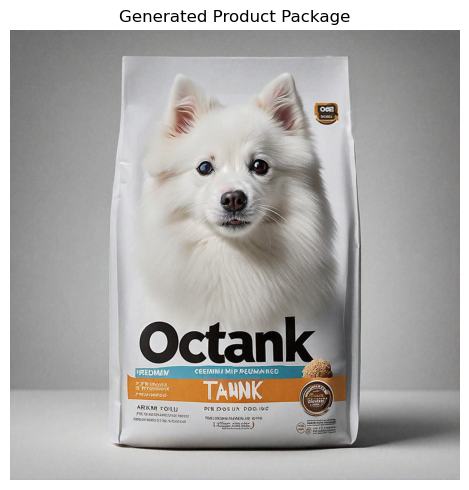

In [160]:
# Generate text-to-image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,                    # Required
            "negativeText": negative_prompts   # Optional
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,   # Range: 1 to 5 
            "quality": "standard",  # Options: standard or premium
            "height": 1024,        # Supported height list in the docs see here: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#w379aac17c27c15c15b7c21b5b7
            "width": 1024,         # Supported width list in the docs see here: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#w379aac17c27c15c15b7c21b5b7
            "cfgScale": 7.5,       # Range: 1.0 (exclusive) to 10.0
            "seed": 42             # Range: 0 to 214783647
        }
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# save output
save_image(response_body.get("images")[0], output_save_path)

# Plot output
plot_images(response_images, processed_title="Generated Product Package") 

### Step 2: Image Conditioning

##### Background

Now, the marketing team wants to leverage a reference image of the company owner's American Eskimo to create a product package design.


In [167]:
# Define the prompt and reference image
prompt = "A white packet of premium dog food with an American Eskimo dog on it, professional product photography. Dog food is named Octank"
reference_image_path = "images/reference_dog.png"
seed = 42

# Specify path to store the output
output_save_path = "images/after_image_conditioning.png" 

Amazon Titan Image Generator v2 offers two image conditioning modes:

- Canny Edge: Extract prominent edges from the reference image to guide the generation process. You can “draw” the foundations of your desired image, and the model will then fill in the details, textures, and final aesthetic based on your guidance.

- Segmentation: Define specific regions/objects within the reference image for the model to generate content aligned with those areas.

![Visual of Canny Edge and Segementation algorithms ](https://d2908q01vomqb2.cloudfront.net/da4b9237bacccdf19c0760cab7aec4a8359010b0/2024/08/01/2024-image-generator-v2-1-color-conditioning.jpg)

Main parameters can be specified include:

* `text` - (Required) A text prompt to generate the image, must be <= 512 characters
* `negativeText` - (Optional) A text prompt to define what not to include in the image, must be <= 512 characters
* `conditionImage` - (Optional, V2 only) A base64-encoded string representing an input image to guide the layout and composition of the generated image
* `controlMode` - (Optional, V2 only) Specifies the type of conditioning mode: `CANNY_EDGE` (default) or `SEGMENTATION`
* `controlStrength` - (Optional, V2 only) Determines how similar the generated image should be to the condition image, range 0 to 1.0 (default: 0.7)
* `numberOfImages` - The number of images to generate
* `height` - The height of the generated image(s)
* `width` - The width of the generated image(s)
* `cfgScale` - Determines how closely the image adheres to the prompt
* `seed` - An integer used to initialize the image generation process

Note: The longer side of the image resolution must be <= 1,408 pixels. If `controlMode` or `controlStrength` are provided, `conditionImage` must also be provided.



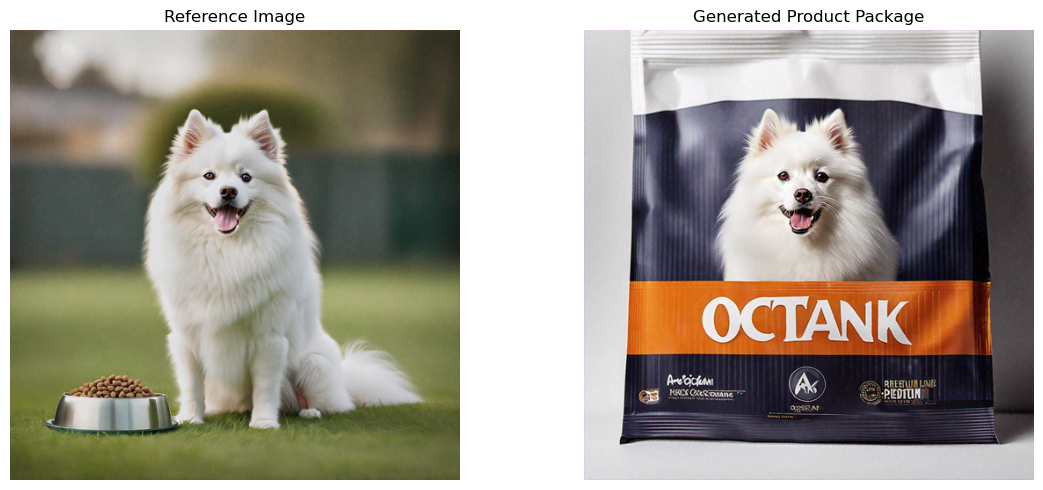

In [168]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image conditioned on reference image
body = json.dumps({
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {
        "text": prompt,
        "conditionImage": reference_image_base64,
        "controlMode": "CANNY_EDGE", #  [OPTIONAL] CANNY_EDGE | SEGMENTATION. DEFAULT: CANNY_EDGE. Refer this blog for details: https://aws.amazon.com/blogs/aws/amazon-titan-image-generator-v2-is-now-available-in-amazon-bedrock/
        "controlStrength": 0.7,
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "seed": seed,
    }
})

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# save output
save_image(response_body.get("images")[0], output_save_path)

# Plot output
plot_images(response_images, ref_image_path=reference_image_path, 
            original_title="Reference Image", processed_title="Generated Product Package")

Result is looking promising! Before we head into next step, let's complete some **bonus tasks** to explore more with image conditioning feature.

#### Background
The marketing team wants now to see how the package looks like with a cartoon version of the same dog.

In [169]:
# Define the prompt, reference image
prompt = "a cartoon dog food packet with a white american eskimo on the packet cover."
reference_image_path = "images/after_image_conditioning.png"
seed = 42 # Can be any random number between 0 to 214783647

# Specify path to store the output
output_save_path = "images/after_image_cartooning.png" 

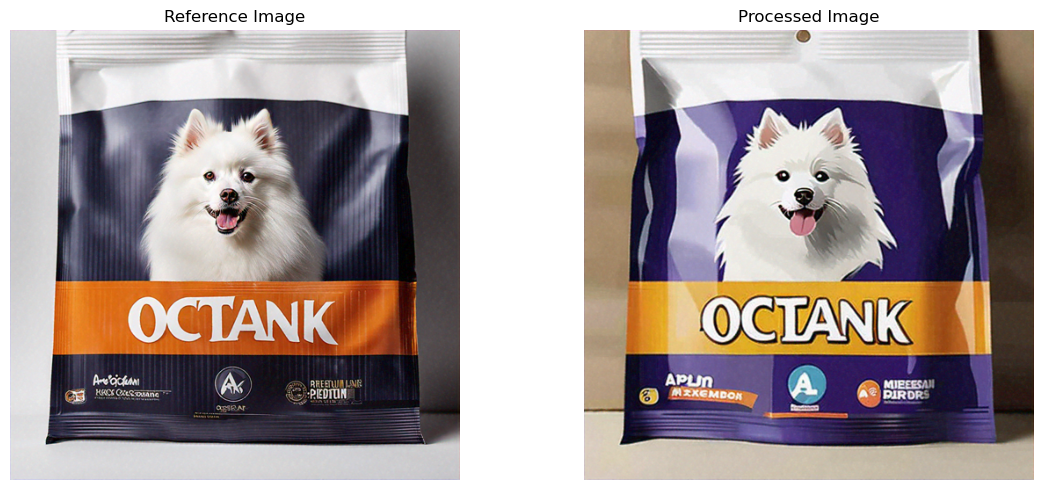

In [170]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,  # Required
            "conditionImage": reference_image_base64, # Optional
            "controlMode": "CANNY_EDGE", # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Range: 0.2 to 1.0,
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

### Step 3: Image Variation

#### Background


Generating images from text is powerful but, in some cases, you will want your model to understand the style from certain image and directly transfer it to your output image.
Rather than starting from scratch, image variation features enables us to do style transfer easily.

Now, Octank wants to have a dog food packet with the same style showing in the reference image, let's see how easy this step could be.

In [171]:
# Define the prompt, reference image
prompt = "A white packet of premium dog food with an American Eskimo dog on it, professional product photography. Dog food is named Octank"
negative_prompt = "bad quality, low resolution, cartoon"
reference_image_path = "images/sketch_dog.png"
seed = 42 # Can be any random number between 0 to 214783647

# Specify path to store the output
output_save_path = "images/after_image_variation.png" 

Image variation allows you to create variations of your original image based on the parameter values. The size limit for the input image are <= 1,408 on the longer side of image.

- text (Optional) – A text prompt that can define what to preserve and what to change in the image. Must be <= 512 characters.
- negativeText (Optional) – A text prompt to define what not to include in the image. Must be <= 512 characters.
- text (Optional) – A text prompt that can define what to preserve and what to change in the image. Must be <= 512 characters.
- similarityStrength (Optional) – Specifies how similar the generated image should be to the input image(s) Use a lower value to introduce more randomness in the generation. Accepted range is between 0.2 and 1.0 (both inclusive), while a default of 0.7 is used if this parameter is missing in the request.



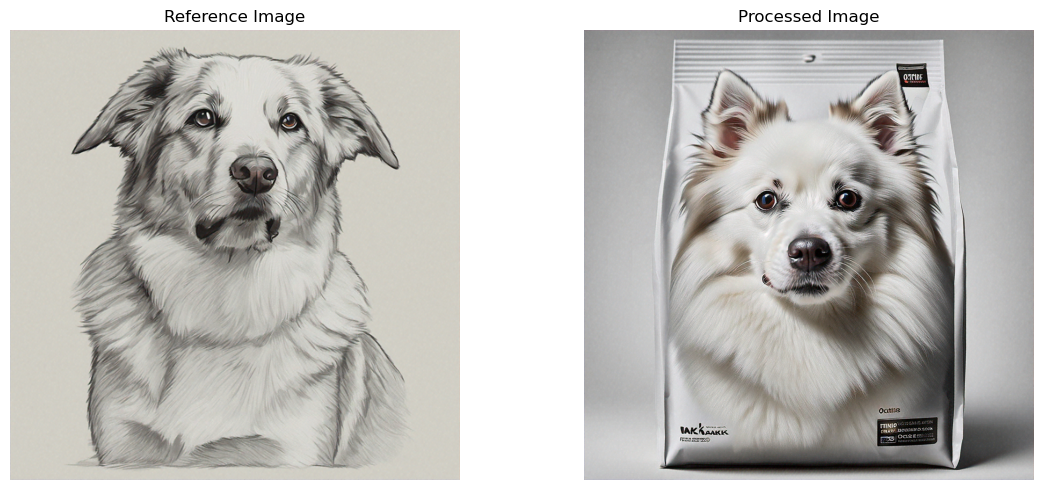

In [172]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

body = json.dumps({
     "taskType": "IMAGE_VARIATION",
     "imageVariationParams": {
         "text": prompt,              # Optional
         "negativeText": negative_prompt,   # Optional
         "images": [reference_image_base64],               # One image is required
        #  "similarityStrength": 1.0
     },
     "imageGenerationConfig": {
         "numberOfImages": 1,
         "quality": "premium",
         "height": 1024,
         "width": 1024,
         "cfgScale": 10,
         "seed": seed
     }
 })

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

### Step 4. Inpainting


#### Background
Octank has decided to refresh their product line by featuring different dog breeds on their packaging. However, they want to maintain consistency in the overall design and only change the dog image. This is where inpainting comes in handy. For this task, Octank wants to replace the American Eskimo dog on their current packaging with a Husky, while keeping the rest of the design intact.

Let's use inpainting to help Octank update their packaging with a new dog breed.

In [173]:
# Define the prompt and reference image
prompt = "A white packet of premium dog food with Husky dog on it, professional product photography. Dog food is named Octank"
negative_prompts = "bad quality, low res"
reference_image_path = "images/after_image_cartooning.png" 
mask_prompt = "American Eskimo dog"
seed = 2 # Can be any random number between 0 to 214783647

`text` (Optional) – A text prompt to define what to change inside the mask. If you don't include this field, the model tries to replace the entire mask area with the background. Must be <= 512 characters. negativeText (Optional) – A text prompt to define what not to include in the image. Must be <= 512 characters. The size limits for the input image and input mask are <= 1,408 on the longer side of image. The output size is the same as the input size.

The `inPaintingParams` fields are described below. The mask defines the part of the image that you want to modify.

- `image` (Required) – The JPEG or PNG image to modify, formatted as a string that specifies a sequence of pixels, each defined in RGB values and encoded in base64. For examples of how to encode an image into base64 and decode a base64-encoded string and transform it into an image, see the code examples.
- You must define one of the following fields (but not both) in order to define.
    - `maskPrompt` – A text prompt that defines the mask.
    - `maskImage` – A string that defines the mask by specifying a sequence of pixels that is the same size as the image. Each pixel is turned into an RGB value of (0 0 0) (a pixel inside the mask) or (255 255 255) (a pixel outside the mask). For examples of how to encode an image into base64 and decode a base64-encoded string and transform it into an image, see the code examples.
- `text` (Optional) – A text prompt to define what to change inside the mask. If you don't include this field, the model tries to replace the entire mask area with the background.
- `negativeText` (Optional) – A text prompt to define what not to include in the image.

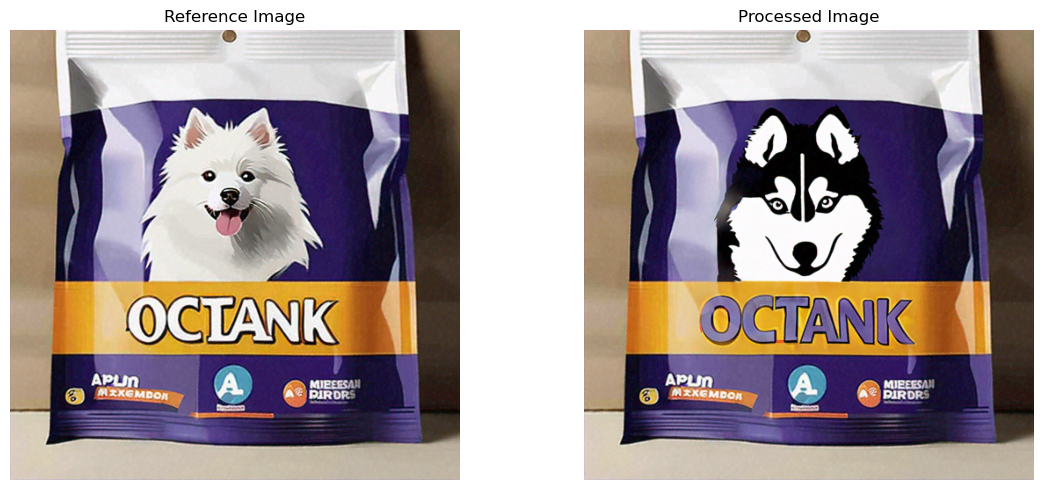

In [174]:
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": prompt,  # Optional - what to change inside the mask
            "negativeText": negative_prompts,    # Optional
            "image": reference_image_base64,  # Required
            "maskPrompt": mask_prompt,  # One of "maskImage" or "maskPrompt" is required
            "returnMask": True, # False by default
            # "maskImage": "base64-encoded string",   

        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

On the other hand, Octank doesn't want some of the generated text on the image. This is where they could leverage the help from inpainting with MaskImage.

In [175]:
# Define the prompt and reference image
negative_prompts = "bad quality, low res"
reference_image_path = "images/after_text-to-image.png" 
mask_image_path = "images/mask-image.png"
seed = 2 # Can be any random number between 0 to 214783647

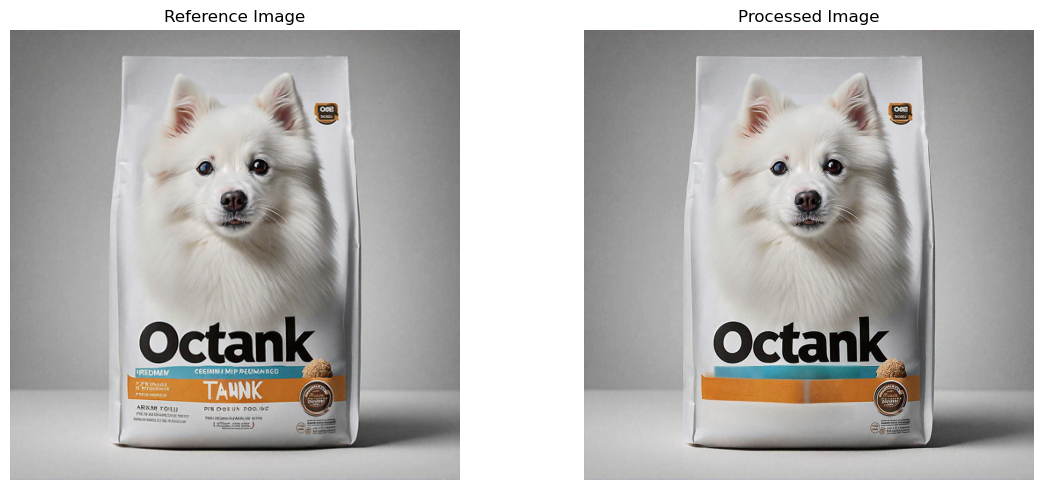

In [176]:
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
with open(mask_image_path, "rb") as image_file:
    mask_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "negativeText": negative_prompts,    # Optional
            "image": reference_image_base64,  # Required
            "maskImage": mask_image_base64,  # One of "maskImage" or "maskPrompt" is required

        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

Here we go! They can get an image on package design without unnecessary text with the help of inpainting feature.

### Step 5: Color Conditioning

#### Background
Now, let's create a special promotional package design using Octank's brand color palette.

In [177]:
# Define the prompt, reference image, color code and path to store the generated images
reference_image_path = "images/after_image_cartooning.png" 
prompt = "a cartoon white american eskimo on the cover of OCTANK dog food packet"
hex_color_code = ['#ffe599', '#3d85c6', '#eeeeee']
seed = 42 # Can be any random number between 0 to 214783647


Amazon Titan Image Generator v2's color conditioning feature allows users to generate images that follow a specified color palette. This can be done with or without a reference image. Here's Octank's color palette:

![image](images/octank_color_palette.JPG)

Here's a summary of the parameters for color conditioning:

* `text` - (Required) A text prompt to generate the image, must be <= 512 characters
* `colors` - (Required) A list of 1 to 10 hex color codes to specify colors in the generated image
* `negativeText` - (Optional) A text prompt to define what not to include in the image, must be <= 512 characters
* `referenceImage` - (Optional) A base64-encoded string representing an input image to guide the color palette of the generated image
* `numberOfImages` - The number of images to generate
* `height` - The height of the generated image(s)
* `width` - The width of the generated image(s)
* `cfgScale` - Determines how closely the image adheres to the prompt
* `seed` - An integer used to initialize the image generation process

Users can (optional) upload a single reference image that is similar to their desired output. The model will then generate images that follow the style and fashion of this reference image while incorporating the specified color palette.

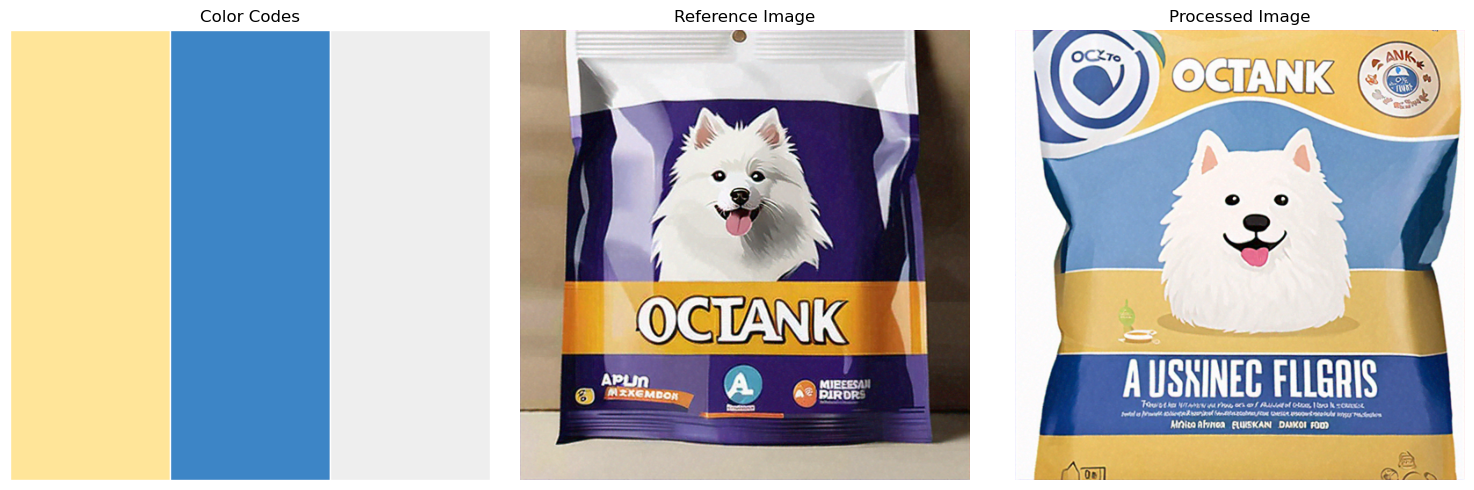

In [178]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
    
# Generate image condition on color palette
body = json.dumps({
    "taskType": "COLOR_GUIDED_GENERATION",
    "colorGuidedGenerationParams": {
        "text": prompt,
        "colors": hex_color_code,
        "referenceImage": reference_image_base64,
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "seed": seed,
    }
})

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]


# plot output
plot_images(response_images, ref_image_path = reference_image_path, color_codes = hex_color_code)

### Step 6: Outpainting

#### Background
Now, Octank wants to create a professional-looking ad with this new product with filming studio background. To do this kind of background replacement, we will use the outpainting feature offered by Titan Image Generator models. 

We will first expand the image size to provide more room, then generating the new image using outpainting feature.

In [179]:
# Define the prompt and reference image
prompt = "filming studio background, the dog food packet is on a stand"
reference_image_path = "images/after_image_cartooning.png" 
mask_prompt = "Dog food packet"
seed = 1 # Can be any random number between 0 to 214783647

# Expansion setting
target_width = 1024
target_height = 1024
horizontal_position_percent=0.3
vertical_position_percent=0.5

# Specify path to store the output
expand_image_path = "images/expanded_image.png"

`text` (Required) – A text prompt to define what to change outside the mask. Must be <= 512 characters. negativeText (Optional) – A text prompt to define what not to include in the image. Must be <= 512 characters. The size limits for the input image and input mask are <= 1,408 on the longer side of image. The output size is the same as the input size.

The `outPaintingParams` fields are defined below. The mask defines the region in the image whose that you don't want to modify. The generation seamlessly extends the region you define.

- `image` (Required) – The JPEG or PNG image to modify, formatted as a string that specifies a sequence of pixels, each defined in RGB values and encoded in base64. For examples of how to encode an image into base64 and decode a base64-encoded string and transform it into an image, see the code examples.
- You must define one of the following fields (but not both) in order to define.
    - `maskPrompt` – A text prompt that defines the mask.
    - `maskImage` – A string that defines the mask by specifying a sequence of pixels that is the same size as the image. Each pixel is turned into an RGB value of (0 0 0) (a pixel inside the mask) or (255 255 255) (a pixel outside the mask). For examples of how to encode an image into base64 and decode a base64-encoded string and transform it into an image, see the code examples.
- `text` (Required) – A text prompt to define what to change outside the mask.
- `negativeText` (Optional) – A text prompt to define what not to include in the image.

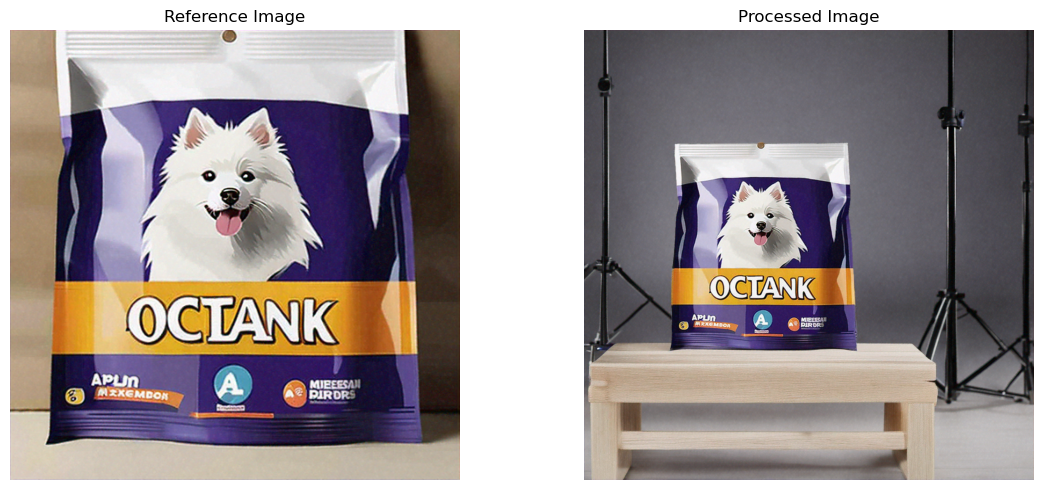

In [180]:
# Load reference image
original_image = Image.open(reference_image_path)
original_width, original_height = original_image.size

# Calculate the position of the original image on the expanded canvas.
position = (
    int((target_width - original_width) * horizontal_position_percent),
    int((target_height - original_height) * vertical_position_percent),
)

# Create an input image which contains the original image with an expanded
# canvas.
input_image = Image.new("RGB", (target_width, target_height), (235, 235, 235))
input_image.paste(original_image, position)
input_image.save(expand_image_path)
    
# Encode the reference image
with open(expand_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": prompt,  # Required
            "image": reference_image_base64,  # Required
            "maskPrompt": mask_prompt,  # One of "maskImage" or "maskPrompt" is required
            "outPaintingMode": "PRECISE",  # One of "PRECISE" or "DEFAULT"
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

### Step 7: Background Removal

#### Background
Octank has professional photos of their existing gourmet dog food. They want to use these images across various marketing materials with different background. In our last use case, we will use Background Removal feature from Titan Image Generator v2 to help Ocktank isolate its product image from their original backgrond.

To use this feature, you just need to provide the image the model needs to work with. 

In [181]:
# Define image needs to be processed and path to store the generated images
reference_image_path = "images/after_image_cartooning.png" 

The background removal task type automatically identifies multiple objects in the input image and removes the background. The output image has a transparent background.

Request format
`{
    "taskType": "BACKGROUND_REMOVAL",
    "backgroundRemovalParams": {
        "image": "base64-encoded string"
    }
}`

Response Format
`{
  "images": [
    "base64-encoded string", 
    ...
  ],
  "error": "string" 
}`

The backgroundRemovalParams field is described below.
- `image` (Required) – The JPEG or PNG image to modify, formatted as a string that specifies a sequence of pixels, each defined in RGB values and encoded in base64.

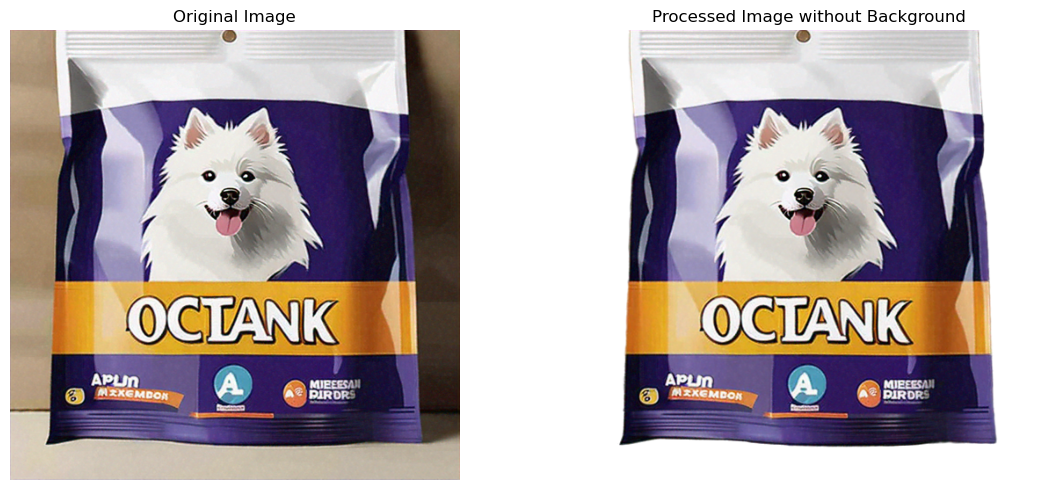

In [182]:
# Read image from file and encode it as base64 string.
with open(reference_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode('utf8')

body = json.dumps({
    "taskType": "BACKGROUND_REMOVAL",
    "backgroundRemovalParams": {
        "image": input_image,
    }
})

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# plot output
plot_images(response_images, ref_image_path= reference_image_path, original_title='Original Image', processed_title='Processed Image without Background')

## Responsible AI in action

To continue supporting best practices in the responsible use of AI, Titan Foundation Models (FMs) are built to detect and remove harmful content in the data, reject inappropriate content in the user input, and filter the models’ outputs that contain inappropriate content (such as hate speech, profanity, and violence). 

Octank marketing team wants generate an appealing campaign by placing and image of Scooby Doo on the package. 

In [183]:
# Define the prompt with some inputs blocked for being copyright image.
prompt = "A white packet of premium dog food with Scooby Doo on it, professional product photography. Dog food is named Octank."
negative_prompts = "poorly rendered, poor background details, poor packet details, poor text details, bleary text"
seed = 42

# Specify path to store the output
output_save_path = "images/after_text-to-image-ri.png" 

In [184]:
# Generate text-to-image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,                    # Required
            "negativeText": negative_prompts   # Optional
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,   # Range: 1 to 5 
            "quality": "standard",  # Options: standard or premium
            "height": 1024,        # Supported height list in the docs see here: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#w379aac17c27c15c15b7c21b5b7
            "width": 1024,         # Supported width list in the docs see here: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#w379aac17c27c15c15b7c21b5b7
            "cfgScale": 7.5,       # Range: 1.0 (exclusive) to 10.0
            "seed": 42             # Range: 0 to 214783647
        }
    }
)

try:
    response = boto3_bedrock.invoke_model(
        body=body, 
        modelId="amazon.titan-image-generator-v2:0",
        accept="application/json", 
        contentType="application/json"
    )
    response_body = json.loads(response.get("body").read())
    response_images = [
        Image.open(io.BytesIO(base64.b64decode(base64_image)))
        for base64_image in response_body.get("images")
    ]

    # save output
    save_image(response_body.get("images")[0], output_save_path)

    # Plot output
    plot_images(response_images, processed_title="Generated Product Package")     

# Handle ValidationException (Responsible AI)
except boto3_bedrock.exceptions.ValidationException as error:
    print(f"An error occurred: {error}")

# Handle all the other errors
except Exception as e:
    # Handle any other unexpected exceptions
    print(f"An unexpected error occurred: {e}")


An error occurred: An error occurred (ValidationException) when calling the InvokeModel operation: This request has been blocked by our content filters. Our filters automatically flagged this prompt because it may conflict our AUP or AWS Responsible AI Policy. Please adjust your text prompt to submit a new request.


#### Amazon Bedrock gives validation error as the input prompt is asking for images of Scooby Dog and hence violates copyright.

## Summary

In this workshop, we explored the powerful features of Amazon Titan Image Generator v2 through the lens of Octank, a premium dog food company. We covered:

- Text to Image
- Image Conditioning
- Color Variation
- Inpainting
- Color Conditioning
- Outpainting
- Background Removal
- Responsible AI in action

These tools enable Octank to efficiently create diverse, high-quality visuals for their marketing campaigns, maintaining brand consistency while adapting to various styles.

You can now leverage this GenAI-powered image generation to enhance your own creative workflows!